<a href="https://colab.research.google.com/github/sivianil/diffusers/blob/main/pokemon_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Pokémon text to image

This notebook demonstrates inference using Stable Diffusion fine tuned on Pokémon to generate new Pokémon form text prompts. The model has been ported to Huggingface Diffusers for easier inference.

For more details about the fine tuning process and how to make your own specialised model see [this guide](https://github.com/LambdaLabsML/examples/tree/main/stable-diffusion-finetuning).

Also see the following links for more info:

- [Lambda Diffusers](https://github.com/LambdaLabsML/lambda-diffusers)
- [Captioned Pokémon dataset](https://huggingface.co/datasets/lambdalabs/pokemon-blip-captions)
- [Model weights in Diffusers format](https://huggingface.co/lambdalabs/sd-pokemon-diffusers)
- [Original model weights](https://huggingface.co/justinpinkney/pokemon-stable-diffusion)
- [Training code](https://github.com/justinpinkney/stable-diffusion)

Created by Justin Pinkney at [Lambda Labs](https://lambdalabs.com/)

In [ ]:
!nvidia-smi

Fri Jul 19 12:27:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8              10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
!pip install diffusers==0.29.2
!pip install transformers==4.42.4 scipy ftfy==6.1.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 27.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 2.3 MB/s eta 0:00:00


In [ ]:
import torch
from diffusers import StableDiffusionPipeline
from torch import autocast

pipe = StableDiffusionPipeline.from_pretrained("lambdalabs/sd-pokemon-diffusers", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors not found


Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

safety_checker/config.json:   0%|          | 0.00/4.65k [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/279 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/522 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/492M [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-pokemon-diffusers/snapshots/0e06bf46e55daafe3f19b16943492e3505c62030/vae: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-pokemon-diffusers/snapshots/0e06bf46e55daafe3f19b16943492e3505c62030/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
An error occurred while trying to fetch /root/.cache/huggingface/hub/models--lambdalabs--sd-pokemon-diffusers/snapshots/0e06bf46e55daafe3f19b16943492e3505c62030/unet: Error no file named diffusion_pytorch_model.safetensors found in directory /root/.cache/huggingface/hub/models--lambdalabs--sd-pokemon-diffusers/snapshots/0e06bf46e55daafe3f19b16943492e3505c62030/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.


In [ ]:
from PIL import Image

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

  0%|          | 0/50 [00:00<?, ?it/s]

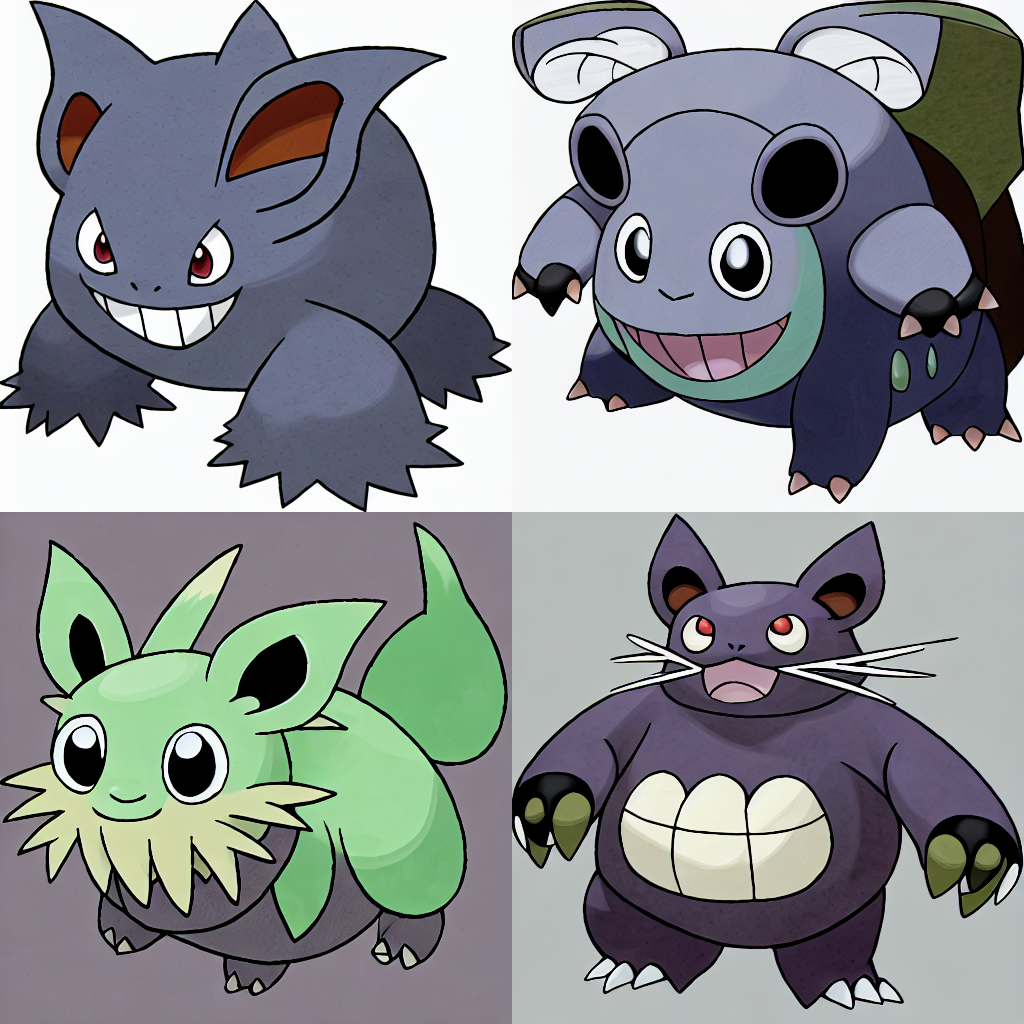

In [ ]:
prompt = "Totoro"
scale = 10
n_samples = 4

# Sometimes the nsfw checker is confused by the Pokémon images, you can disable
# it at your own risk here
disable_safety = False

if disable_safety:
  def null_safety(images, **kwargs):
      return images, False
  pipe.safety_checker = null_safety

with autocast("cuda"):
  images = pipe(n_samples*[prompt], guidance_scale=scale).images

grid = image_grid(images, rows=2, cols=2)
grid